In [1]:
import os
os.chdir('drive/My Drive/MLProject_20202')

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from utils import format_length, get_lstm_vectors, get_doc2vec_vectors, plot_loss,\
                    plot_cm, plot_metrics, plot_prc, plot_roc

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
df_cat = pd.read_csv('Data/data_all_categorical.csv', encoding='utf-8')
y = df_cat.fraudulent

df_cat_no_target = df_cat.loc[:, df_cat.columns != 'fraudulent']
categorical_vectors = df_cat_no_target.to_numpy()

In [5]:
MODEL_TYPE = 'lstm'
MODEL_INPUT = 8
MODEL_OUTPUT = 256

In [6]:
df = pd.read_json("Data/data_text_embedded.json")
embedded_text = df.embedded_text.tolist()

In [7]:
lstm_model = keras.models.load_model(f'Model/LSTM/model_{MODEL_TYPE}_{MODEL_OUTPUT}_{MODEL_INPUT}.h5')

In [8]:
context_vectors = get_lstm_vectors(lstm_model, MODEL_INPUT, MODEL_OUTPUT, embedded_text)

In [9]:
X = np.concatenate((context_vectors ,categorical_vectors), axis = 1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [11]:
# initial bias
pos = sum(y==1)
neg = sum(y==0)

initial_bias = np.log([pos/neg])
initial_bias

array([-2.9779069])

In [12]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = pos + neg
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.53
Weight for class 1: 10.32


In [67]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(X_train, metrics=METRICS, output_bias=None, hidden_size=64):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          hidden_size, activation='relu',
          input_shape=(X_train.shape[-1],)),
    #   keras.layers.Dropout(0.5),
      keras.layers.Dense(
          256, activation='relu'),
      keras.layers.Dense(
          256, activation='relu'),
    #   keras.layers.Dropout(0.5),
      keras.layers.Dense(
          128, activation='relu'),
    #   keras.layers.Dropout(0.5),
      keras.layers.Dense(
          128, activation='relu'),
      keras.layers.Dense(
          64, activation='relu'),
      keras.layers.Dense(
          64, activation='relu'),
    #   keras.layers.Dense(
    #       16, activation='relu'),
    #   keras.layers.Dense(
    #       16, activation='relu'),
    #   keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [68]:
EPOCHS = 400
BATCH_SIZE = 512
HIDDEN_SIZE = 256

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [69]:
weighted_model = make_model(X_train, output_bias=initial_bias, hidden_size=HIDDEN_SIZE)

# weighted_model.layers[-1].bias.assign([0.0])
weighted_history = weighted_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/400
23/23 [==============================] - 4s 71ms/step - loss: 0.9178 - tp: 93.9583 - fp: 1911.3750 - tn: 4143.2917 - fn: 202.2917 - accuracy: 0.7267 - precision: 0.0371 - recall: 0.2523 - auc: 0.5190 - prc: 0.0520 - val_loss: 0.5940 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2703.0000 - val_fn: 158.0000 - val_accuracy: 0.9448 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7004 - val_prc: 0.1642
Epoch 2/400
23/23 [==============================] - 1s 25ms/step - loss: 0.6735 - tp: 155.8333 - fp: 3020.5417 - tn: 3033.3750 - fn: 141.1667 - accuracy: 0.5142 - precision: 0.0472 - recall: 0.5223 - auc: 0.5573 - prc: 0.0738 - val_loss: 0.6821 - val_tp: 126.0000 - val_fp: 1208.0000 - val_tn: 1495.0000 - val_fn: 32.0000 - val_accuracy: 0.5666 - val_precision: 0.0945 - val_recall: 0.7975 - val_auc: 0.7507 - val_prc: 0.2224
Epoch 3/400
23/23 [==============================] - 1s 26ms/step - loss: 0.6488 - tp: 167.2083 - fp: 2405.0417 - tn: 3654.8750 - fn: 1

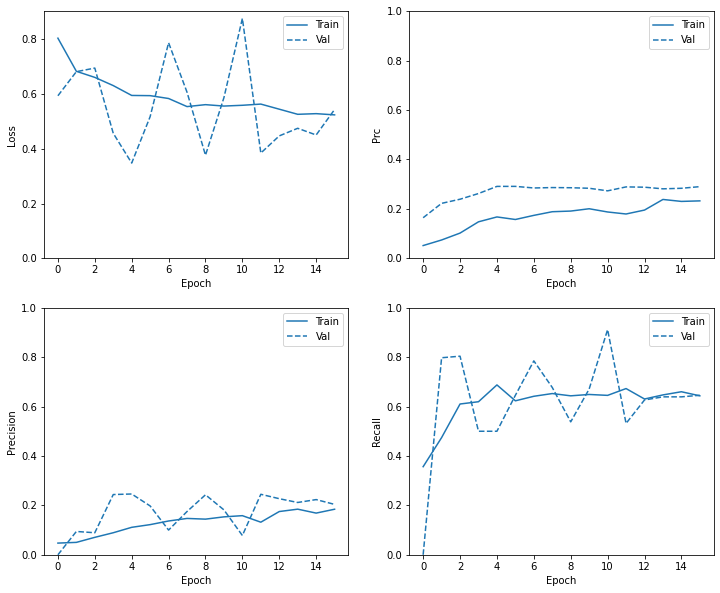

In [70]:
plot_metrics(weighted_history, colors)

In [71]:
train_predictions_weighted = weighted_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_test, batch_size=BATCH_SIZE)

loss :  0.5129677057266235
tp :  117.0
fp :  511.0
tn :  2901.0
fn :  47.0
accuracy :  0.8439597487449646
precision :  0.18630573153495789
recall :  0.7134146094322205
auc :  0.8080447912216187
prc :  0.26350313425064087

True Job Postings Detected (True Negatives):  2901
True Job Postings Incorrectly Detected (False Positives):  511
False Job Postings Missed (False Negatives):  47
False Job Postings Detected (True Positives):  117
Total False Job Postings:  164


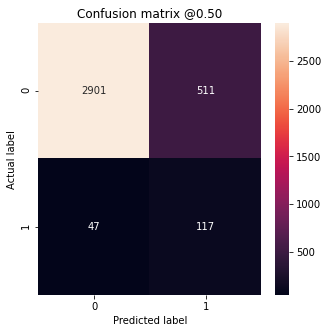

In [72]:
weighted_results = weighted_model.evaluate(X_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)

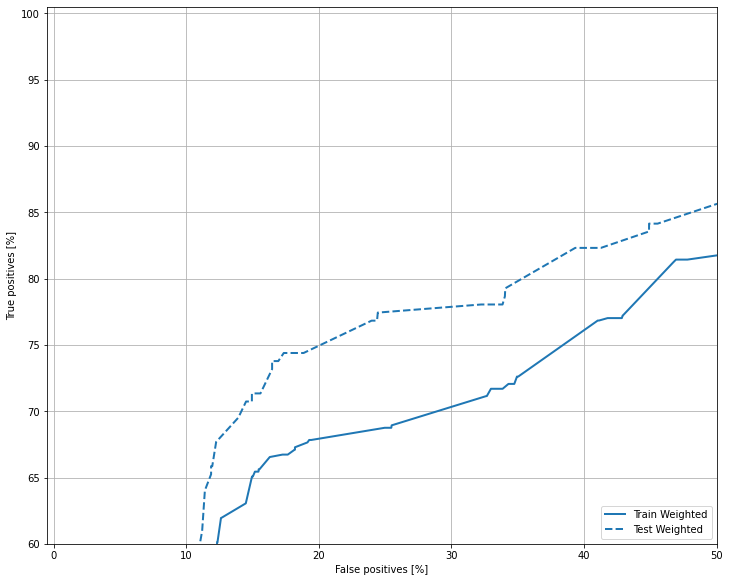

In [73]:
plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[0])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

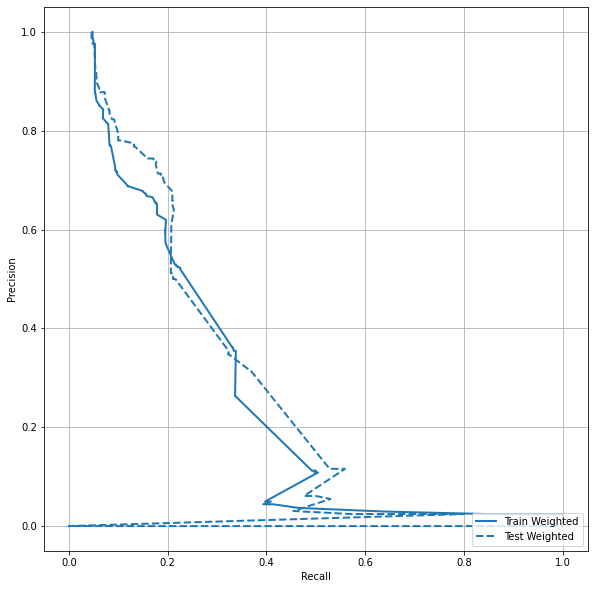

In [74]:
plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[0])
plot_prc("Test Weighted", y_test, test_predictions_weighted, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [75]:
weighted_model.save(f'Model/LSTM/Classification/NN_{MODEL_TYPE}')

INFO:tensorflow:Assets written to: Model/LSTM/Classification/NN_lstm/assets
